<strong><h1>Random Forest Algorithm</h1></strong>


In [70]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint, uniform

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

#Exporting model
import pickle

In [71]:
data = pd.read_csv('../../dataset/dataset_final.csv', sep=',')
data['Target'] = data['Target'].map({'Dropout':0,'Enrolled':1,'Graduate':2})
data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,Target
0,-4.362150,-1.007771,-2.563540,1.331845,-1.075936,-1.368674,-0.191537,-0.373345,-0.803115,0.837092,1.623067,-0.261753,0.235638,-0.326818,0
1,-0.241665,-0.291954,-1.576865,-1.195618,1.024771,0.349829,-0.015485,-0.468722,-0.327269,0.175780,-2.409748,-0.823892,-0.581045,-0.973223,2
2,-2.704703,0.883059,0.227150,-0.584111,-0.216966,-0.617850,0.370419,0.055970,-1.348930,-0.152507,-2.033690,0.099927,-1.232974,-0.678305,0
3,0.366266,-0.237005,0.779684,-0.273035,-0.053979,-0.070852,-0.957714,-1.342641,-0.319636,-0.506683,-0.036937,1.136352,0.300461,-0.328121,2
4,0.002403,2.173728,-0.855346,1.884833,1.329653,0.679385,-0.600227,-0.520670,0.723744,0.238530,0.123345,0.951798,-0.536999,0.329798,2


In [72]:
X_dataWithoutTarget = data.drop('Target', axis=1)
Y_target = data['Target']


#Split dataset into 70% training and 30% (testing + validation)
X_train, X_testval, y_train, y_testval = train_test_split(X_dataWithoutTarget, Y_target, test_size=0.3, random_state=42)

#Split the remaining 30% into 20% testing and 10% validation
X_test, X_val, y_test, y_val = train_test_split(X_testval, y_testval, test_size=1/3, random_state=42)

#Check the resulting sizes
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")
print(f"Validation set: {len(X_val)} samples")

Training set: 4638 samples
Testing set: 1326 samples
Validation set: 663 samples


Training a Random Forest Model without hyper parameter testing (For Comparison)


In [73]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
y_pred = rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8114630467571644


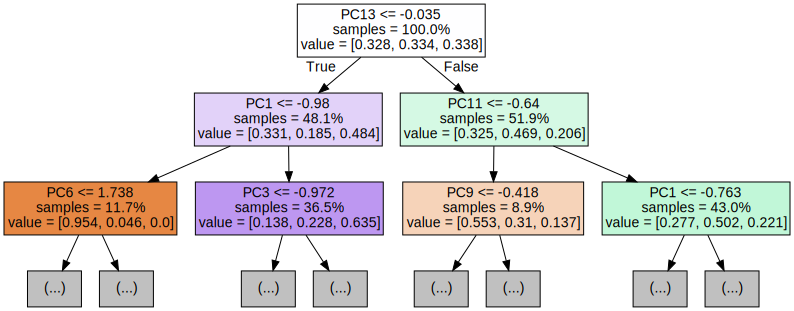

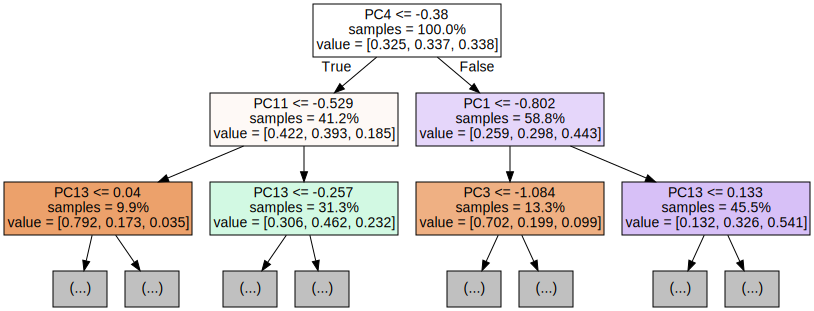

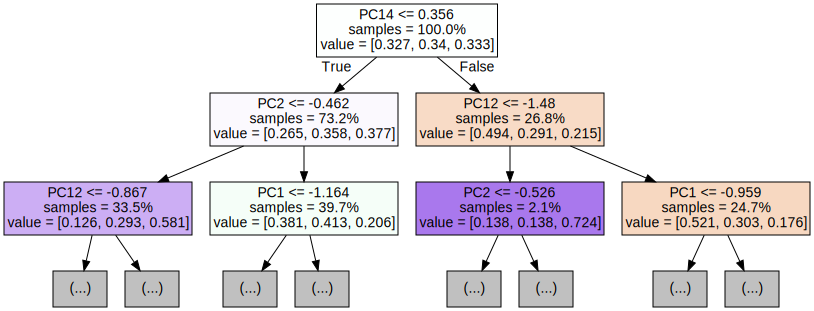

In [75]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [76]:
param_dist = {
    'n_estimators': randint(50, 500),           # Number of trees
    'max_depth': randint(1, 20),                # Maximum depth of the tree
    'min_samples_split': randint(2, 20),        # Minimum number of samples to split a node
    'min_samples_leaf': randint(1, 20),         # Minimum samples required at a leaf node
    'max_features': uniform(0.1, 0.9),          # Fraction of features considered for splitting
    'bootstrap': [True, False],                 # Whether bootstrap samples are used
}

hyper_rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(
    hyper_rf,
    param_distributions=param_dist,
    n_iter=100,  # More iterations for better exploration
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',  # Choose appropriate metric
    random_state=42,      # For reproducibility
    n_jobs=-1            # Use all processors for faster computation
)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8B1F4B0E0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001F8B07713A0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8B07695E0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8B06B0AD0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001F8B0637560>},
                   random_state=42, scoring='accuracy')

In [77]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'bootstrap': True, 'max_depth': 14, 'max_features': np.float64(0.3650445521554869), 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 193}


In [78]:
y_pred = best_rf.predict(X_val)
best_rf_accuracy = accuracy_score(y_val, y_pred)
print("Hyperparameter Accuracy:", best_rf_accuracy)

Hyperparameter Accuracy: 0.7812971342383107


In [79]:
differenceBetweenAccuracies = abs(accuracy - best_rf_accuracy)
print("Accuracy difference:", differenceBetweenAccuracies)

Accuracy difference: 0.0301659125188537


<strong><h3>Exporting the model</h3></strong>


In [80]:
# Save the model to a file
with open('random_forest_model.pkl', 'wb') as f:
    if (best_rf_accuracy > accuracy):
        print("Exporting hyper parameter trained model")
        pickle.dump(best_rf, f)
    else:
        print("Exporting non-hyper parameter trained model")
        pickle.dump(rf, f)
print("Model exported successfully!")

Exporting non-hyper parameter trained model
Model exported successfully!


In [81]:
# Load the model from the file
with open('random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Test predictions
y_pred = loaded_model.predict(X_test)
finalAccuracy = accuracy_score(y_test, y_pred)
print("Final accuracy:", finalAccuracy)

Final accuracy: 0.77526395173454
